In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates
import japanize_matplotlib
import datetime as dt
# 県名の英語/日本語対応
EN_pref = ['ALL', 'Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima', 'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa', 'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 'Nagano', 'Gifu', 'Shizuoka', 'Aichi', 'Mie', 
           'Shiga', 'Kyoto', 'Osaka', 'Hyogo', 'Nara','Wakayama','Tottori', 'Shimane', 'Okayama', 'Hiroshima', 'Yamaguchi', 'Tokushima', 'Kagawa', 'Ehime', 'Kochi', 'Fukuoka', 'Saga', 'Nagasaki', 'Kumamoto', 'Oita', 'Miyazaki','Kagoshima','Okinawa']
JP_pref = ["全国", '北海道', '青森県', '岩手県', '宮城県', '秋田県', '山形県', '福島県', '茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県', '新潟県', '富山県', '石川県', '福井県', '山梨県', '長野県',  '岐阜県', '静岡県', '愛知県', '三重県',
           '滋賀県', '京都府', '大阪府', '兵庫県', '奈良県', '和歌山県', '鳥取県', '島根県', '岡山県', '広島県', '山口県', '徳島県', '香川県', '愛媛県', '高知県', '福岡県', '佐賀県', '長崎県', '熊本県', '大分県', '宮崎県', '鹿児島県', '沖縄県'] 
JP_pref_of = dict(zip(EN_pref, JP_pref))
# 厚労省ホームページからデータを読込む
# 新規陽性者数を cases に取り込み，日付をインデックスにする
cases_url = "https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv" # データの在処
cases = pd.read_csv(cases_url) # データフレームに取り込む
cases["Date"] = pd.to_datetime(cases["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
cases = cases.set_index("Date") # "Date"列をインデックスに設定
# 累積死亡者数データを読込む
deaths_url = "https://covid19.mhlw.go.jp/public/opendata/deaths_cumulative_daily.csv" # データの在処
deaths = pd.read_csv(deaths_url) # データフレームに取り込む
deaths["Date"] = pd.to_datetime(deaths["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
deaths = deaths.set_index("Date") # "Date"列をインデックスに設定
deaths = deaths.diff() # 差分を取って新規死亡者数に変換
# 入院等の治療を要する者(=患者数）を読込む
patients_url = "https://covid19.mhlw.go.jp/public/opendata/requiring_inpatient_care_etc_daily.csv" # データの在処
patients_orig = pd.read_csv(patients_url) # まずは全てのデータをデータフレーム hosp_orig に取り込む
patients_orig["Date"] = pd.to_datetime(patients_orig["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
patients_orig = patients_orig.set_index("Date") # "Date"列をインデックスに設定

# 「入院治療等を要する者」だけのデータフレーム hosp を作成する
patients = patients_orig[["({}) Requiring inpatient care".format(pref) for pref in cases.columns]]
patients.columns = EN_pref # 列の名前を全国("ALL")と47都道府県名にする

# 重症者数
severe_url = "https://covid19.mhlw.go.jp/public/opendata/severe_cases_daily.csv" # データの在処
severe = pd.read_csv(severe_url) # データフレームに取り込む
severe["Date"] = pd.to_datetime(severe["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
severe = severe.set_index("Date") # "Date"列をインデックスに設定
# read_csv を使って CSV 形式のデータを読込む
hospitalized = pd.read_csv('https://www.stopcovid19.jp/data/covid19japan_beds/all.csv')
# 更新日を日付データに置き換える
hospitalized["更新日"] = pd.to_datetime(hospitalized["更新日"])
# なぜか未来の日付のデータが混入しているので取除く
hospitalized = hospitalized[hospitalized["更新日"]<=dt.datetime.today()]
# fillna(0)でデータ欠損部分をゼロ埋めし，整数型に変換する
hospitalized["入院者数"] = hospitalized["入院者数"].fillna(0).astype(int)
# read_csv を使って CSV 形式のデータを読込む
hospitalized = pd.read_csv('https://www.stopcovid19.jp/data/covid19japan_beds/all.csv')
# 更新日を日付データに置き換える
hospitalized["更新日"] = pd.to_datetime(hospitalized["更新日"])
# なぜか未来の日付のデータが混入しているので取除く
hospitalized = hospitalized[hospitalized["更新日"]<=dt.datetime.today()]
# fillna(0)でデータ欠損部分をゼロ埋めし，整数型に変換する
hospitalized["入院者数"] = hospitalized["入院者数"].fillna(0).astype(int)
hospitalized = hospitalized.set_index(["都道府県番号","更新日"])["入院者数"].sort_index().unstack().T
hospitalized = pd.concat([hospitalized.sum(axis=1), hospitalized], axis=1)
hospitalized.columns = EN_pref
# マルチインデックスのデータフレームにまとめる
jp_df = pd.concat([cases.stack(), deaths.stack(), patients.stack(), hospitalized.stack(), severe.stack()], axis=1).swaplevel(0,1).sort_index().loc[EN_pref]
jp_df.columns=["cases", "deaths", "patients", "hospitalized", "severe_cases"]


# 全国および各県の累積陽性数のオーダーを取得する
total_case = jp_df.cases.groupby(level=0).sum()
all_case_order = np.log10(total_case["ALL"]).astype(int)+1
pref_case_order = np.log10(total_case["Hokkaido":].max()).astype(int)+1
all_case_order, pref_case_order

# グラフ描画関数# グラフ描画関数
def plot_pref(pref_set, back_weeks=-1):
    cols = 3
    rows = np.ceil(len(pref_set)/cols).astype(int)
    fig, ax_tab = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
    ## カラム間の調整
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    axs = ax_tab.flatten()
    if back_weeks == -1:
        start_date = jp_df.index.get_level_values(1)[0]
    else:
        start_date = dt.datetime.today()-dt.timedelta(weeks=back_weeks)
    for pid, pref in enumerate(pref_set):
        ax = axs[pid]
        nc = jp_df.loc[pref].cases # 当該県の新規陽性数
        td = jp_df.loc[pref].deaths # 当該県の死亡数
        pt = jp_df.loc[pref].patients # 当該県の患者数
        hc = jp_df.loc[pref].hospitalized.dropna() # 当該県の入院者数
        sc = jp_df.loc[pref].severe_cases # 当該県の重症数
        # 累積陽性・死亡数
        ax.plot( nc.cumsum(), label="累積陽性数", color="C0", lw=2, zorder=2 )
        ax.plot( td.cumsum(), label="累積死亡数", color="C1", lw=2, zorder=2 )
        # 新規陽性・死亡数
        ax.fill_between( nc.index, nc.rolling(7).mean(), lw=0, color="C0", label="新規陽性数",alpha=0.25 )
        ax.fill_between( td.index, td.rolling(7).mean(), lw=0, color="C1", label="新規死亡数",alpha=0.25 )
        # 入院・重症
        ax.plot( pt, color="C2", label="患者数", ls='--' )
        ax.plot( hc, color="C3", label="入院者数", ls='--')
        ax.plot( sc, color="C4", label="重症数", ls='--' )
        # グラフの縦軸を整える
        ax.set_yscale('log')
        if pref == "ALL":
            ax.set_ylim([1,10**all_case_order])
            ax.legend(loc='upper left')
        else:
            ax.set_ylim([1, 10**pref_case_order])
        ax.set_title(JP_pref_of[pref])
        ## x軸の主目盛りを修正
        ax.xaxis.set_major_locator(mdates.MonthLocator()) # 主目盛りを月ごとに設定
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%y %b")) # 主目盛りの表示を英語の月名短縮形にする
        ax.grid(which='major', axis='x', linestyle='-', color='tab:cyan', alpha=0.5) # 主目盛りのグリッドを水色にして，半透明にする
        ax.set_xlim((start_date, nc.index[-1]))
        plt.setp(ax.get_xticklabels(which='major'), rotation=90)
    return fig, axs

# 地域別にプロットする
prefs_in = {'全国': ['ALL'],
            '北海道・東北':['Hokkaido', 'Aomori', 'Akita', 'Iwate', 'Miyagi', 'Yamagata', 'Fukushima'],
           '関東':['Tokyo', 'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Kanagawa'],
           '北陸・中部':['Niigata', 'Toyama', 'Ishikawa', 'Fukui','Yamanashi', 'Nagano', 'Gifu', 'Shizuoka', 'Aichi'],
           '近畿':['Kyoto', 'Osaka', 'Mie', 'Shiga', 'Hyogo', 'Nara', 'Wakayama'],
           '中国':['Tottori', 'Shimane', 'Okayama', 'Hiroshima', 'Yamaguchi'],
           '四国':['Tokushima', 'Kagawa', 'Ehime', 'Kochi'],
           '九州・沖縄':['Fukuoka', 'Saga', 'Nagasaki', 'Oita', 'Kumamoto', 'Miyazaki', 'Kagoshima', 'Okinawa']}
def plot_by_area(in_df, back_weeks=-1, yscale="log", is_step=False, total_ylim=None, pref_ylim=None): # 
    rows = 4
    cols = 2
    fig, ax_tab = plt.subplots(rows, cols, figsize=(8*cols,6*rows))
    ## カラム間の調整
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    axs = ax_tab.flatten()
    # x の表示範囲
    dates = in_df.index.get_level_values(1)
    if back_weeks == -1:
        start_date = dates[0]
    else:
        start_date = dt.datetime.today()-dt.timedelta(weeks=back_weeks)
    xlim = (start_date, dates[-1])

    # y の表示範囲
    in_df = in_df[dates>=start_date]
    max_df = in_df.groupby(level=0).max()
    min_df = in_df.groupby(level=0).min()
    if yscale=='log':
        if total_ylim is None:
            max_order = np.ceil(np.log10(in_df.groupby(level=0).max()))
            min_order = np.floor(np.log10(in_df.groupby(level=0).min()))
            total_max_order = max_order["ALL"]
            total_min_order = min_order["ALL"]
            total_ylim = [10**total_min_order, 10**total_max_order]
        if pref_ylim is None:
            pref_max_order = max_order.iloc[1:].max()
            pref_min_order = min_order.iloc[1:].min()
            pref_ylim = [10**pref_min_order, 10**pref_max_order]
        print("total_ylim", total_ylim)
        print("pref_ylim", pref_ylim)
    else:
        if total_ylim is None:
            total_ylim = [0, max_df["ALL"]*1.1]
        if pref_ylim is None:
            pref_ylim = [0, max_df.iloc[1:].max()*1.1]
        print("total_ylim", total_ylim)
        print("pref_ylim", pref_ylim)

    for rid, region in enumerate(prefs_in):
        ax = axs[rid]
        for pref in prefs_in[region]:
            if pref not in in_df.index.get_level_values(level=0):
                continue
            if is_step:
                ax.step(in_df.loc[pref].index, in_df.loc[pref], label=JP_pref_of[pref])
            else:
                ax.plot(in_df.loc[pref], label=JP_pref_of[pref])
            ax.set_yscale(yscale)
            if region=="全国":
                ylim = total_ylim
            else:
                ylim = pref_ylim
        # 見栄えを整える
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_title(region)
        ax.legend(loc="lower left")
        ax.xaxis.set_major_locator(mdates.MonthLocator()) # 主目盛りを月ごとに設定
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%y %b")) # 主目盛りの表示を英語の月名短縮形にする
        ax.grid(which='major', axis='x', linestyle='-', color='tab:cyan', alpha=0.5) # 主目盛りのグリッドを水色にして，半透明にする
        ax.grid(which='major', axis='y', linestyle='-', color='tab:grey', alpha=0.5) # y軸主目盛りのグリッドを灰色にして，半透明にする
        plt.setp(ax.get_xticklabels(which='major'), rotation=90) # 90度回転

    return in_df, fig, axs

total_ylim [0, 1.5]
pref_ylim [0, 1.5]


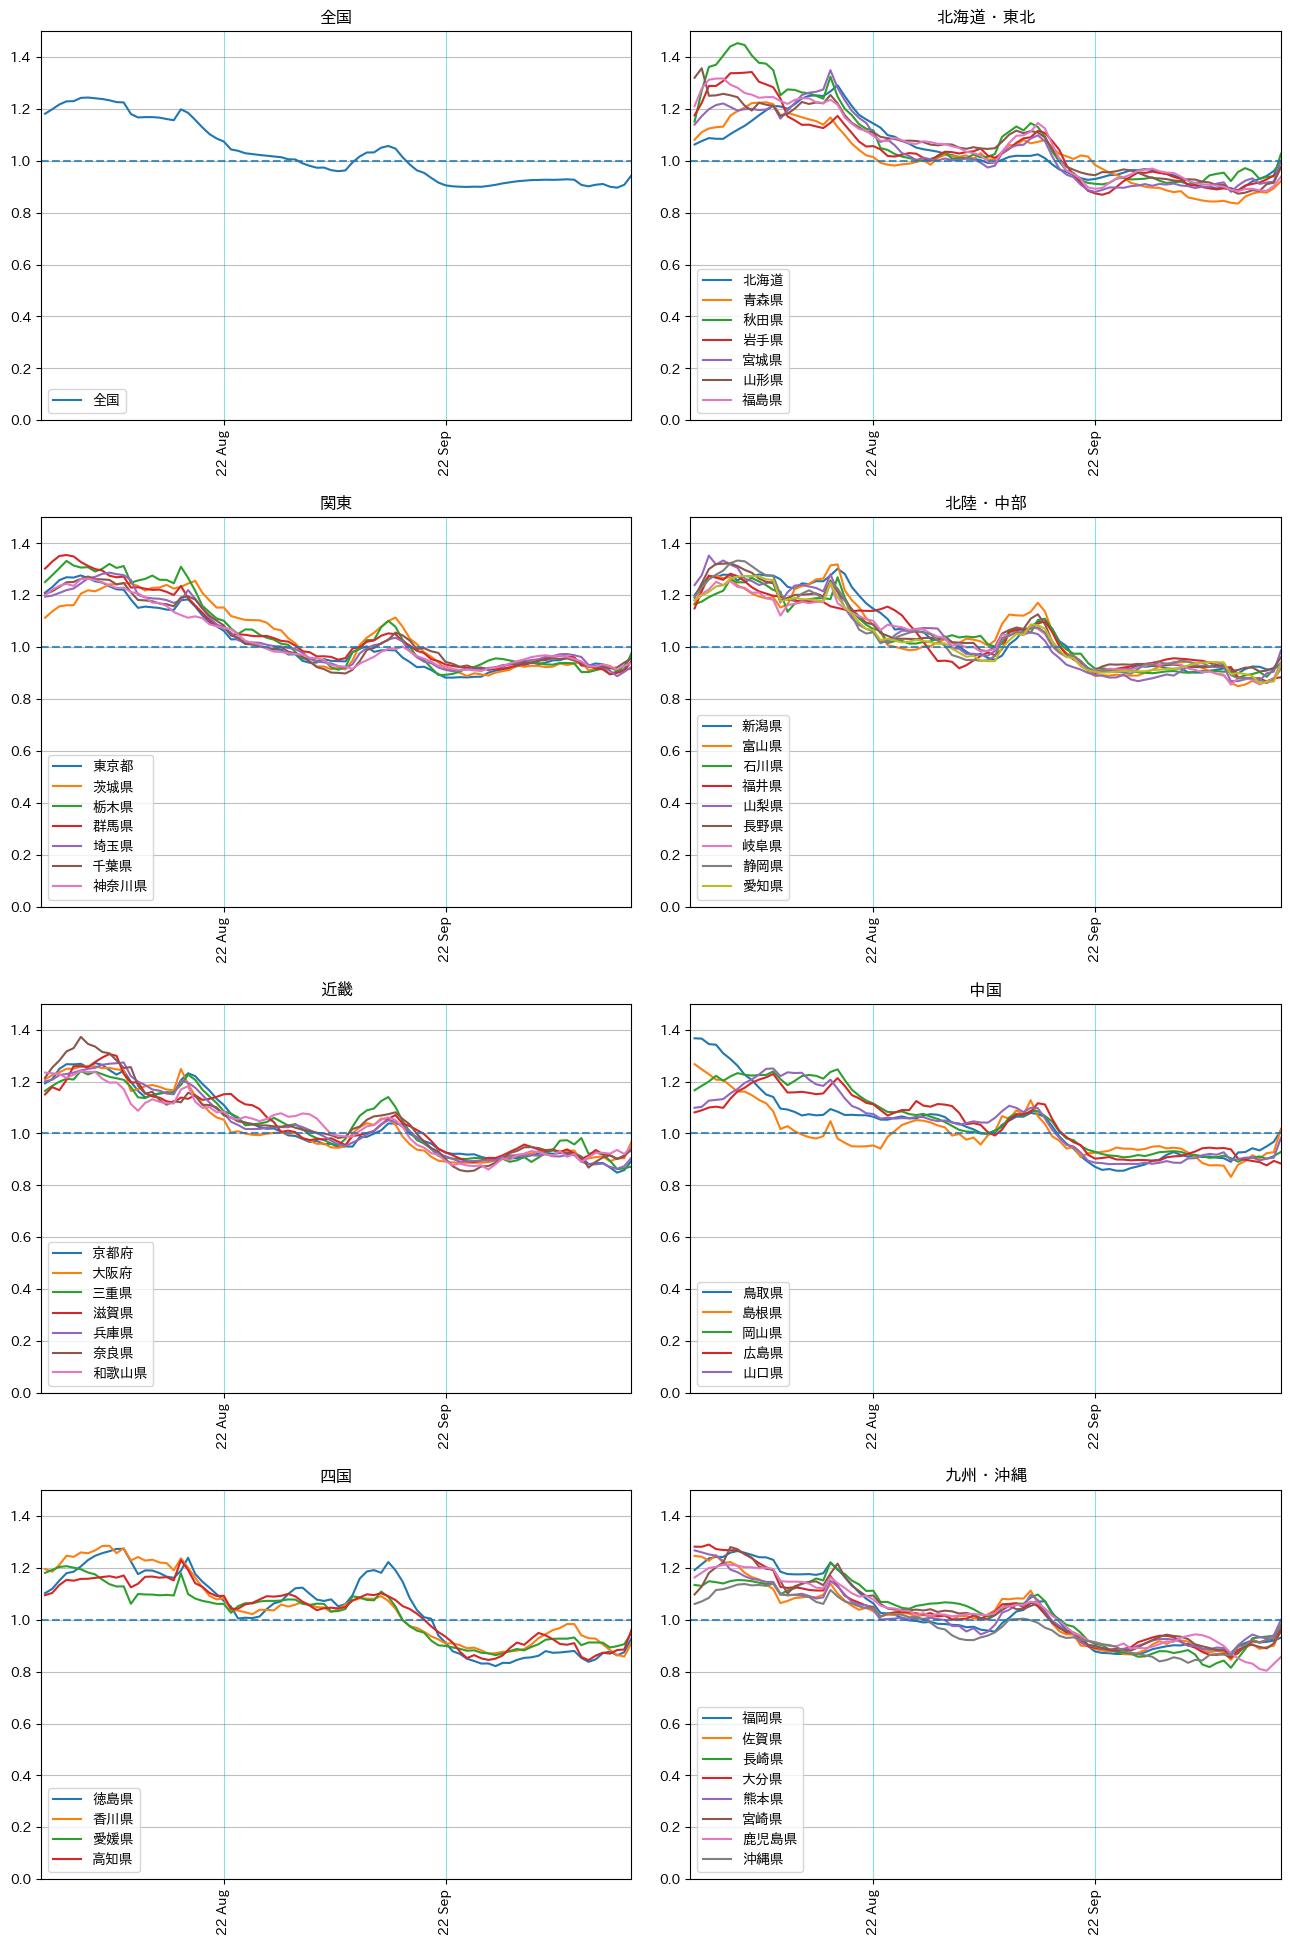

In [3]:
# 実効再生産数(「1週間あたりの感染者数」同士の「世代時間前」との比）
bw = 12 # どれだけ遡るか
tw = 7 # 発生期間
# gd = 5 # 世代時間
gd = 2 # 世代時間(オミクロン株が主流となった状況を反映させるため．下記の東洋経済オンラインを参照）
# https://toyokeizai.net/sp/visual/tko/covid19/
cc = jp_df.cases.cumsum().diff(tw)
Rt = (cc/cc.shift(tw))**(gd/tw)
tdf, fig, axs = plot_by_area(Rt, back_weeks=bw, yscale="linear", total_ylim=[0,1.5], pref_ylim=[0,1.5])
for ax in axs:
    ax.hlines(1.0, *ax.get_xlim(), linestyle='--', alpha=0.8)


total_ylim [0, 1.5]
pref_ylim [0, 1.5]


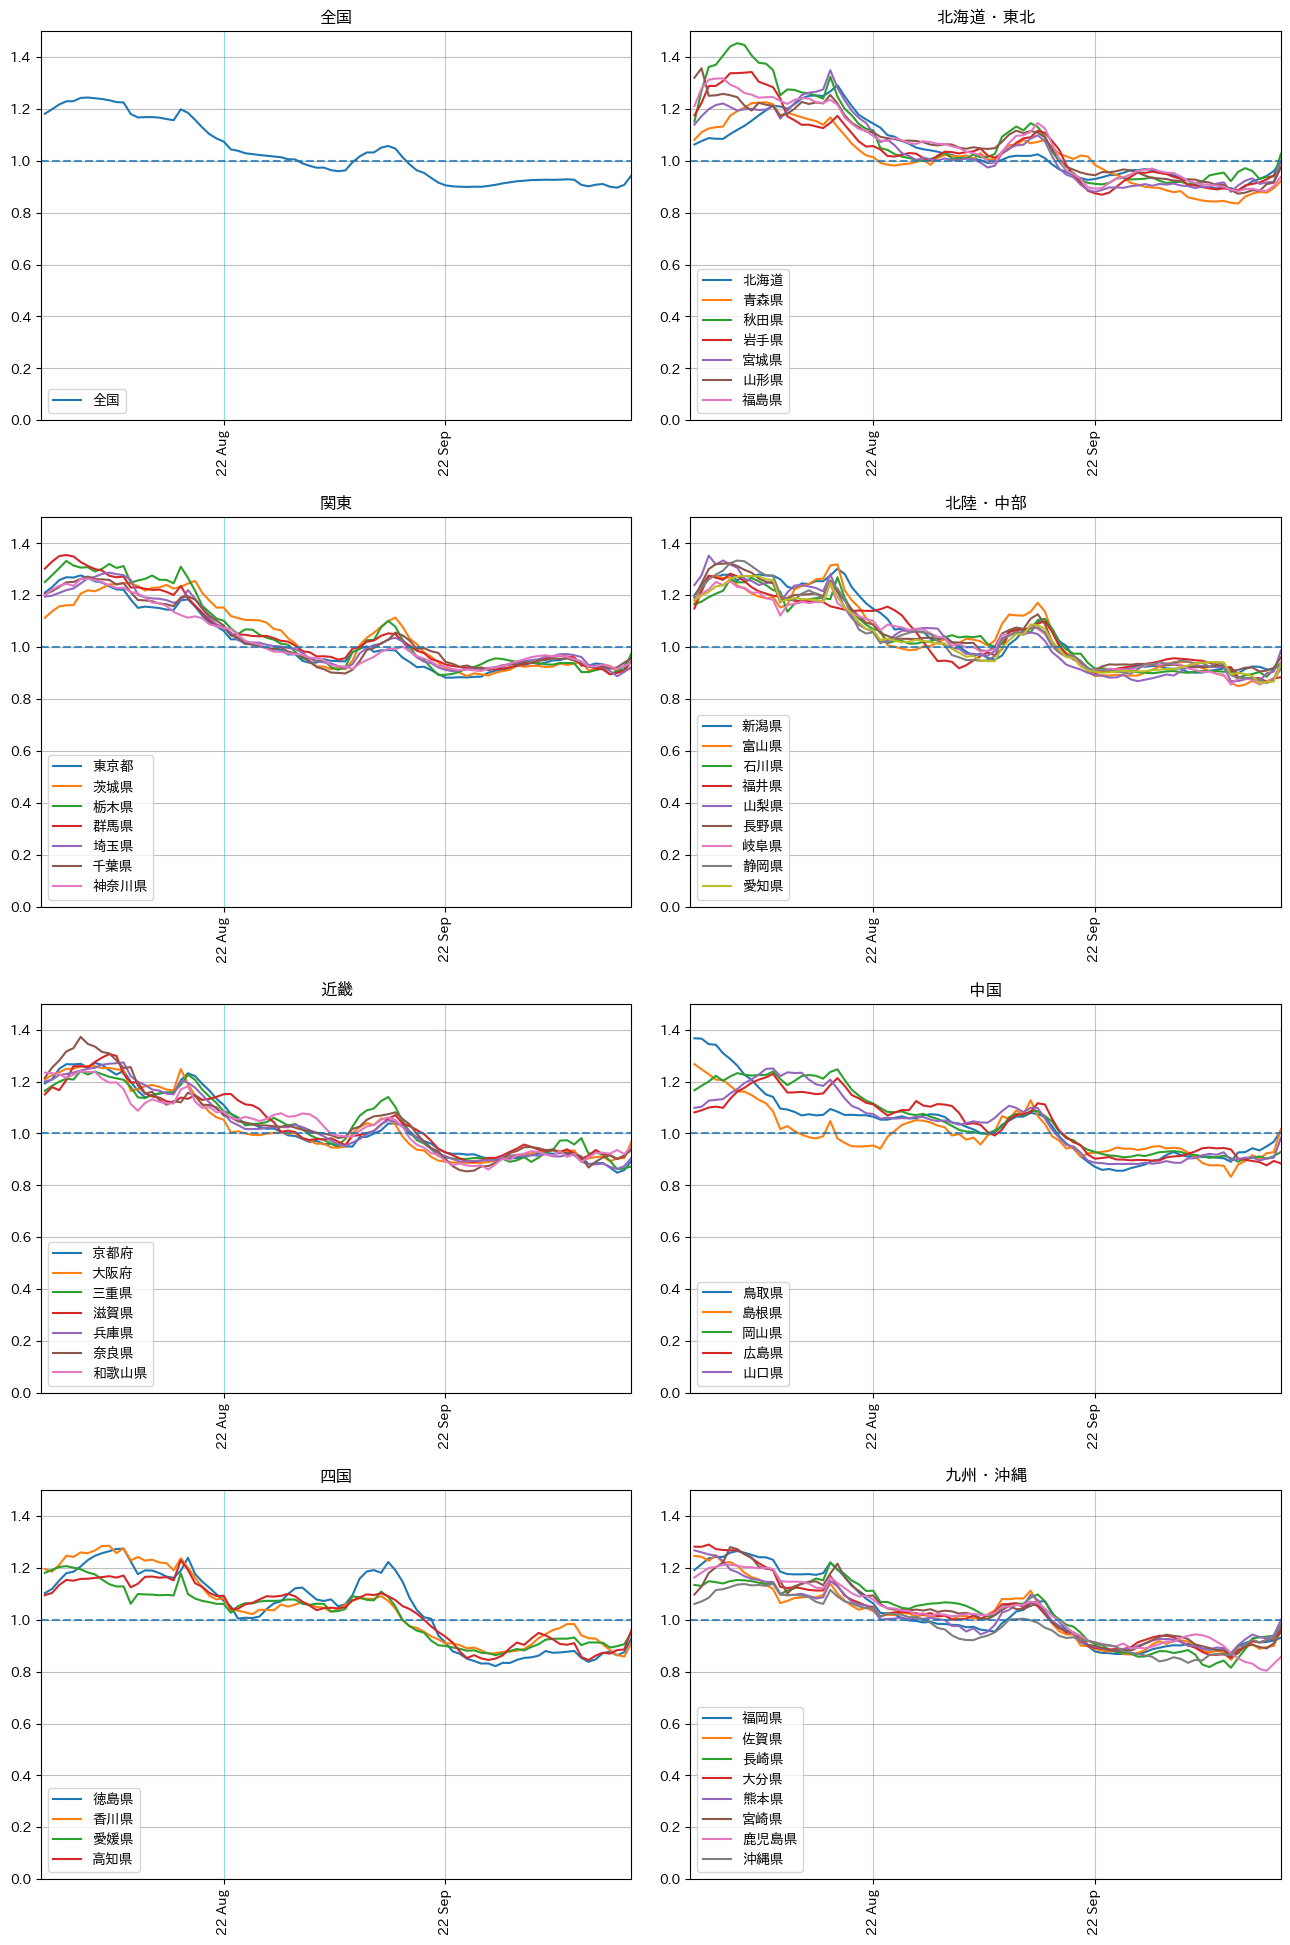

In [75]:
# 実効再生産数((「直近7日間の感染者数」/「その前7日間の感染者数」)^(「平均世代期間」/「報告期間」))
tw = 7 # 発生期間・報告期間
# gd = 5 # 世代時間
gd = 2 # 平均世代時間(オミクロン株が主流となった状況を反映させるため．下記の東洋経済オンラインを参照）
# https://toyokeizai.net/sp/visual/tko/covid19/
cc = jp_df.cases.cumsum().diff(tw)
Rt = (cc/cc.shift(tw))**(gd/tw)
tdf, fig, axs = plot_by_area(Rt, back_weeks=bw, yscale="linear", total_ylim=[0,1.5], pref_ylim=[0,1.5])
for ax in axs:
    ax.hlines(1.0, *ax.get_xlim(), linestyle='--', alpha=0.8)
#fig.savefig("fig/CoVid19-Japan-recent-Rt_by_area.png", bbox_inches='tight')

In [ ]:
# 全国+47都道府県を4つに分けて描画し，グラフに保存
for sid in range(4):
    pref_set = EN_pref[sid*12:(sid+1)*12]
    fig, ax = plot_pref(pref_set)
    fig.savefig('fig/CoVid19-Japan-cases_by_pref-{}.png'.format(sid), bbox_inches='tight')

# 直近16週間だけをプロット
for sid in range(4):
    pref_set = EN_pref[sid*12:(sid+1)*12]
    fig, ax = plot_pref(pref_set, back_weeks=16)
    fig.savefig('fig/CoVid19-Japan-cases_by_pref-{}-recent.png'.format(sid), bbox_inches='tight')


#
bw = 12 # どれだけ遡るか
tw = 7 # 移動平均
# 新規陽性者数
nc = jp_df.cases.rolling(tw).mean().dropna()
tdf, fig, axs = plot_by_area(nc, back_weeks=bw)
fig.savefig("fig/CoVid19-Japan-recent-cases_by_area.png", bbox_inches='tight')

# 新規死亡者数
nd = jp_df.deaths.rolling(tw).mean().dropna()
tdf, fig, ax = plot_by_area(nd, back_weeks=bw, yscale="linear")
fig.savefig("fig/CoVid19-Japan-recent-deaths_by_area.png", bbox_inches='tight')

# 入院者数
hs = jp_df.hospitalized.dropna()
tdf, fig, ax = plot_by_area(hs, back_weeks=bw, yscale="linear", is_step=True)
fig.savefig("fig/CoVid19-Japan-recent-hospitalized_by_area.png", bbox_inches='tight')

# 重症者数
sc = jp_df.severe_cases
tdf, fig, ax = plot_by_area(sc, back_weeks=bw, yscale="linear", is_step=True)
fig.savefig("fig/CoVid19-Japan-recent-severe_cases_by_area.png", bbox_inches='tight')

fig.savefig("fig/CoVid19-Japan-recent-Rt_by_area.png", bbox_inches='tight')

# 患者数あたりの入院者
hs_by_pt = jp_df.hospitalized/jp_df.patients
hs_by_pt = hs_by_pt[(jp_df.hospitalized>0) & (jp_df.patients>0)].dropna()
tdf, fig, ax = plot_by_area(hs_by_pt, back_weeks=52, yscale="log")
fig.savefig("fig/CoVid19-Japan-hospitalized_per_patients_by_area.png", bbox_inches='tight')

# 患者数あたりの重症者
sc_by_pt = jp_df.severe_cases/jp_df.patients
sc_by_pt = sc_by_pt[(jp_df.severe_cases>0) & (jp_df.patients>0)].rolling(7).mean()
tdf, fig, ax = plot_by_area(sc_by_pt, back_weeks=52, yscale="log")
fig.savefig("fig/CoVid19-Japan-severe_cases_per_patients_by_area.png", bbox_inches='tight')

# 患者数あたりの死亡者
nd_by_pt = jp_df.deaths/jp_df.patients
nd_by_pt = nd_by_pt[(jp_df.deaths>0) & (jp_df.patients>0)].rolling(7).mean()
tdf, fig, ax = plot_by_area(nd_by_pt, back_weeks=52, yscale="log")
fig.savefig("fig/CoVid19-Japan-deaths_per_patients_by_area.png", bbox_inches='tight')


#
# 地域ごとに集計化された患者あたりの入院者，重症者，死亡率をプロット
#
tw = 7
rows = 4
cols = 2
fig, ax_tab = plt.subplots(rows, cols, figsize=(8*cols,6*rows))
## カラム間の調整
plt.subplots_adjust(wspace=0.1, hspace=0.25)
axs = ax_tab.flatten()

jp_nc, jp_nd, jp_pt, jp_sc = jp_df.cases, jp_df.deaths, jp_df.patients, jp_df.severe_cases
jp_hs = jp_df.hospitalized.dropna()
dates = jp_pt[jp_pt>0].index.get_level_values(level=1)
for rid, region in enumerate(prefs_in):
    ax = axs[rid]
    nc = jp_nc.loc[prefs_in[region]].groupby(level=1).sum()
    nd = jp_nd.loc[prefs_in[region]].groupby(level=1).sum()
    pt = jp_pt.loc[prefs_in[region]].groupby(level=1).sum()
    sc = jp_sc.loc[prefs_in[region]].groupby(level=1).sum()
    hs = jp_hs.loc[prefs_in[region]].groupby(level=1).sum()
    hs_pt = hs/pt[hs.index]
    sc_pt = (sc/pt)[(sc>0) & (pt>0)]
    nd_pt = (nd/pt)[(nd>0) & (pt>0)].rolling(tw).mean()
    ax.plot(hs_pt, label="入院率")
    ax.plot(sc_pt, label="重症率")
    ax.plot(nd_pt, label="死亡率")
    if rid == 0:
        ax.legend()
        ax.set_ylabel("患者1名あたりの入院・重症・死亡者数")
    ax.set_title(region)
    ax.set_yscale('log')
    ax.set_xlim([dates[0], dates[-1]])
    ## x軸の主目盛りを修正
    ax.xaxis.set_major_locator(mdates.MonthLocator()) # 主目盛りを月ごとに設定
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y %b")) # 主目盛りの表示を英語の月名短縮形にする
    ax.grid(which='major', axis='x', linestyle='-', color='tab:cyan', alpha=0.5) # 主目盛りのグリッドを水色にして，半透明にする
    ax.grid(which='major', axis='y', linestyle='-', color='tab:grey', alpha=0.5) # y軸主目盛りのグリッドを灰色にして，半透明にする
    plt.setp(ax.get_xticklabels(which='major'), rotation=90) # 90度回転

ymax = max([ax.get_ylim()[1] for ax in axs])
ymin = min([ax.get_ylim()[0] for ax in axs])
for ax in axs:
    ax.set_ylim([ymin, ymax])
fig.savefig("fig/CoVid19-Japan-ratios_by_area.png", bbox_inches='tight')

#
# 全国の患者1名あたりの入院・重症・死亡者数
#
fig, ax = plt.subplots(1,1,figsize=(8,6))
all_df = jp_df.loc["ALL"]
nd = all_df.deaths
pt = all_df.patients
sc = all_df.severe_cases
hs = all_df.hospitalized.dropna()
dates = pt[pt>0].index
hs_pt = hs/pt[hs.index]
sc_pt = (sc/pt)[(sc>0) & (pt>0)]
nd_pt = (nd/pt)[(nd>0) & (pt>0)].rolling(tw).mean()
ax.plot(hs_pt, label="入院者数/患者数")
ax.plot(sc_pt, label="重症者数/患者数")
ax.plot(nd_pt, label="新規死亡者数/患者数(7日間移動平均)")
ax.legend()
ax.set_title("患者1名あたりの入院・重症・死亡者数\n<情報源>\n- 入院者数：厚労省「療養状況等及び入院患者受入病床数等に関する調査\n- 患者数: 厚労省「オープンデータ」入院治療等を要する者\n- 新規死亡者数: 厚労省「オープンデータ」死亡者数(累積)の差分")
ax.set_yscale('log')
ax.set_xlim([dates[0], dates[-1]])
## x軸の主目盛りを修正
ax.xaxis.set_major_locator(mdates.MonthLocator()) # 主目盛りを月ごとに設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y %b")) # 主目盛りの表示を英語の月名短縮形にする
ax.grid(which='major', axis='x', linestyle='-', color='tab:cyan', alpha=0.5) # x軸主目盛りのグリッドを水色にして，半透明にする
ax.grid(which='major', axis='y', linestyle='-', color='tab:grey', alpha=0.5) # y軸主目盛りのグリッドを灰色にして，半透明にする
plt.setp(ax.get_xticklabels(which='major'), rotation=90) # 90度回転
fig.savefig("fig/CoVid19-Japan-ratios.png", bbox_inches='tight')